In [31]:
# first of all we import the python libraries we need
import numpy as np
import pandas as pd
import sklearn as sklearn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import mean_absolute_error, r2_score
import seaborn as sns

In [32]:
#TENNIS MATCH DURATION MODEL 
#Best-of-3 and Best-of-5 Models
#We started by downloading 10 years of comprehensive match data from GitHub
#We then load all of those 1-year files into one DataFrame
df = pd.concat(
    [pd.read_csv(f"data/atp_matches_{i}.csv") for i in range(2015, 2025)],
    ignore_index=True
)
#As already said, our data sets are VERY comprehensive. Thus we have to remove many columns to enhance readability of our dataset and 
#to reduce noise
unnecessary = [
    'score','w_ace','w_df','w_svpt','w_1stIn','w_1stWon','w_2ndWon','w_SvGms',
    'w_bpSaved','w_bpFaced','l_ace','l_df','l_svpt','l_1stIn','l_1stWon','l_2ndWon',
    'l_SvGms','l_bpSaved','l_bpFaced','winner_name','loser_name',
    'winner_entry','loser_entry','tourney_id','tourney_name','tourney_date',
    'draw_size', 'match_num', 'winner_id', 'winner_hand',
    'loser_id', 'loser_hand', 'winner_rank_points', 'loser_rank_points'
]

df.drop(columns=unnecessary, inplace = True)

#After that we'd like to see where in our data set we have NaNs - as we can see, almost 3000 entries do not have a duration provided e.g.
df.isna().sum()
df['tourney_level'].unique()

array(['A', 'G', 'D', 'M', 'F', 'O'], dtype=object)

In [33]:
#In our data, we still have three categorical variables: surface(e.g. grass/ hard), tourney level (e.g. G for Grand Slam)
#and round (e.g. F for final). It is important to encode those variables so that our machine can work with them:
df = df.dropna(subset=['round', 'minutes', 'winner_rank', 'surface','loser_rank'])
df = df[df['tourney_level'].isin(['A', 'D','G', 'M'])]

#First we get dummy variables for surface and tourney level
df = pd.get_dummies(
    df,
    columns=['surface', 'tourney_level'],
    drop_first=False  # keep ALL levels to avoid missing dummy columns
)

#Then we convert our rounds to a numeric scale
round_map = {
    'R128': 1, 'R64': 2, 'R32': 3, 'R16': 4,
    'QF': 5, 'SF': 6, 'F': 7, 'BR': 8, 'RR': 9
}

df['round'] = df['round'].map(round_map)

#Now we remove matches with unrealistic duration
# -------------------------------------------
df = df[df['minutes'] > 20].copy()
df = df[df['minutes'] < 300].copy()

#Createing engineered features
df["rank_diff"] = abs(df["winner_rank"] - df["loser_rank"])
df["age_diff"] = abs(df["winner_age"] - df["loser_age"])
df["height_diff"] = abs(df["winner_ht"] - df["loser_ht"])
df["same_country"] = (df["winner_ioc"] == df["loser_ioc"]).astype(int)
if "winner_seed" in df.columns and "loser_seed" in df.columns:
    df["winner_seed"] = df["winner_seed"].fillna(0)
    df["loser_seed"]  = df["loser_seed"].fillna(0)
    df["seed_diff"]   = df["winner_seed"] - df["loser_seed"]
else:
    df["seed_diff"] = 0  # fallback if seeds don't exist

#We now want to drop those rows where one or more essential values are NaN


In [34]:
#Selecting features (detect dummy columns dynamically)
surface_cols = [col for col in df.columns if col.startswith("surface_")]
tourney_cols = [col for col in df.columns if col.startswith("tourney_level_")]

features = (
    ["winner_rank", "loser_rank",
    "winner_age", "loser_age", "age_diff",
    "round", "height_diff", "seed_diff",
    "same_country"]
    + surface_cols
    + tourney_cols
)

target = "minutes"

#Splitting into Best-of-3 and Best-of-5
df_best3 = df[df["best_of"] == 3].copy()
df_best5 = df[df["best_of"] == 5].copy()

print("Best-of-3 matches:", len(df_best3))
print("Best-of-5 matches:", len(df_best5))
display(df.head())


Best-of-3 matches: 19655
Best-of-5 matches: 4727


,winner_seed,winner_ht,winner_ioc,winner_age,loser_seed,loser_ht,loser_ioc,loser_age,best_of,round,...,surface_Hard,tourney_level_A,tourney_level_D,tourney_level_G,tourney_level_M,rank_diff,age_diff,height_diff,same_country,seed_diff
0,0.0,183.0,AUS,25.5,0.0,185.0,USA,23.7,3,3,...,True,True,False,False,False,67.0,1.8,2.0,0,0.0
1,0.0,185.0,FIN,33.4,0.0,180.0,USA,22.3,3,3,...,True,True,False,False,False,50.0,11.1,5.0,0,0.0
2,0.0,183.0,AUS,22.9,6.0,183.0,FRA,30.0,3,3,...,True,True,False,False,False,104.0,7.1,0.0,0,-6.0
3,0.0,188.0,FRA,27.8,0.0,180.0,KAZ,27.4,3,3,...,True,True,False,False,False,41.0,0.4,8.0,0,0.0
4,0.0,191.0,SVK,25.4,0.0,183.0,AUT,33.6,3,3,...,True,True,False,False,False,76.0,8.2,8.0,0,0.0


In [35]:
#Train/Test Split

X3 = df_best3[features]
y3 = df_best3[target]

X5 = df_best5[features]
y5 = df_best5[target]

X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=0.2, random_state=42)
X5_train, X5_test, y5_train, y5_test = train_test_split(X5, y5, test_size=0.2, random_state=42)

In [36]:
#We use Random Forests for this task because tennis match duration has nonlinear relationships(e.g., ranking-gap effects) 
#and interactions (surface × format). RF models these patterns without heavy preprocessinga and is robust to outliers
rf3 = RandomForestRegressor(
    n_estimators=500,
    max_depth=None,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='sqrt',
    random_state=42
)

rf5 = RandomForestRegressor(
    n_estimators=500,
    max_depth=None,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='sqrt',
    random_state=42
)

rf3.fit(X3_train, y3_train)
rf5.fit(X5_train, y5_train)


RandomForestRegressor(max_features='sqrt', min_samples_leaf=2,
                      min_samples_split=5, n_estimators=500, random_state=42)

In [37]:
#We then evaluate our model's performance

y3_pred = rf3.predict(X3_test)
y5_pred = rf5.predict(X5_test)

print("\n\033[1m=== BEST-OF-3 MODEL ===\033[0m")
print("MAE:", mean_absolute_error(y3_test, y3_pred))
print("R2 :", r2_score(y3_test, y3_pred))

print("\n\033[1m=== BEST-OF-5 MODEL ===\033[0m")
print("MAE:", mean_absolute_error(y5_test, y5_pred))
print("R2 :", r2_score(y5_test, y5_pred))



=== BEST-OF-3 MODEL ===
MAE: 26.530485612627174
R2 : -0.006731591118482649

=== BEST-OF-5 MODEL ===
MAE: 38.522392817570505
R2 : 0.03870340981002929


In [26]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error

# --- Split by format ---
df_bo3 = df[df['best_of'] == 3].copy()
df_bo5 = df[df['best_of'] == 5].copy()

# --- Features ---
features = ['winner_rank','loser_rank','rank_diff','winner_age','loser_age',
            'age_diff','height_diff','round','seed_diff','same_country']

# Add dummy columns
features += [col for col in df_bo3.columns if 'surface_' in col or 'tourney_level_' in col]

X3, y3 = df_bo3[features], df_bo3['minutes']
X5, y5 = df_bo5[features], df_bo5['minutes']

# --- Train/test ---
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=0.2, random_state=42)
X5_train, X5_test, y5_train, y5_test = train_test_split(X5, y5, test_size=0.2, random_state=42)

# --- Two separate models ---
model3 = XGBRegressor(
    n_estimators=300, learning_rate=0.05, max_depth=4,
    subsample=0.8, colsample_bytree=0.8, random_state=42
)

model5 = XGBRegressor(
    n_estimators=300, learning_rate=0.05, max_depth=4,
    subsample=0.8, colsample_bytree=0.8, random_state=42
)

model3.fit(X3_train, y3_train)
model5.fit(X5_train, y5_train)

y3_pred = model3.predict(X3_test)
y5_pred = model5.predict(X5_test)

print("Bo3 R²:", r2_score(y3_test, y3_pred))
print("Bo3 MAE:", mean_absolute_error(y3_test, y3_pred))
print("Bo5 R²:", r2_score(y5_test, y5_pred))
print("Bo5 MAE:", mean_absolute_error(y5_test, y5_pred))


Bo3 R²: 0.024535912406444593
Bo3 MAE: 26.584959409198422
Bo5 R²: 0.03907799647673815
Bo5 MAE: 37.61237833187052


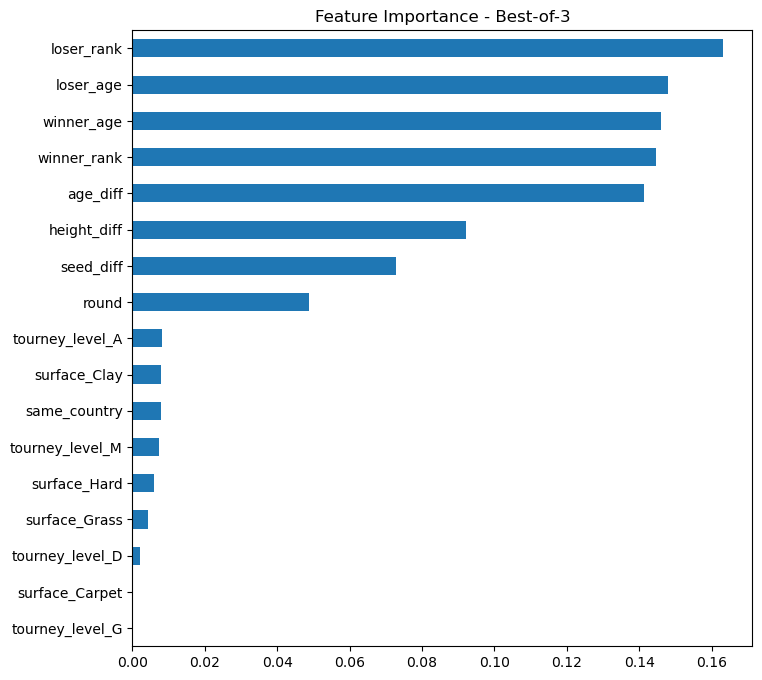

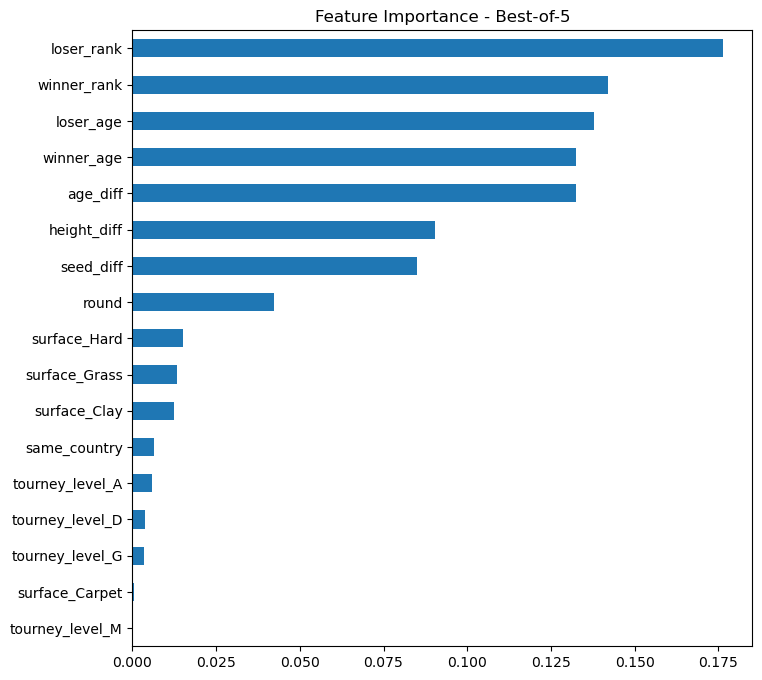

In [39]:
# Feature Importance (plots)
features3 = X3_train.columns.tolist()
features5 = X5_train.columns.tolist()

def plot_importances(model, feature_list, title):
    importances = pd.Series(model.feature_importances_, index=feature_list)
    importances.sort_values().plot(kind="barh", figsize=(8, 8))
    plt.title(title)
    plt.show()

plot_importances(rf3, features3, "Feature Importance - Best-of-3")
plot_importances(rf5, features5, "Feature Importance - Best-of-5")

In [42]:
#Prediction Function (User Inputs -> Match Duration)

def predict_duration(
    player1_rank,
    player2_rank,
    player1_age,
    player2_age,
    surface,           # "Hard", "Clay", "Grass"
    tourney_level,     # "A", "G", "M", "O", "F"
    round,             # "R32", "R16", "QF", "SF", "F"
    best_of           # 3 or 5
):
    # Determine higher/lower ranks (lower = better ranking)
    higher_rank = min(player1_rank, player2_rank)
    lower_rank  = max(player1_rank, player2_rank)

    # Determine player ages similarly
    higher_age = max(player1_age, player2_age)
    lower_age  = min(player1_age, player2_age)

    # Create input row
    row = pd.DataFrame([[0]*len(features)], columns=features)

    # Core numeric features
    row["winner_rank"] = higher_rank     # model expects "winner_rank" = better player
    row["loser_rank"]  = lower_rank
    row["rank_diff"]   = abs(player1_rank - player2_rank)

    row["winner_age"]  = higher_age
    row["loser_age"]   = lower_age
    row["age_diff"]    = abs(player1_age - player2_age)

    row["best_of"] = best_of

    # Round mapping
    round_map = {
        'R128': 1, 'R64': 2, 'R32': 3, 'R16': 4,
        'QF': 5, 'SF': 6, 'F': 7, 'BR': 8, 'RR': 9
    }
    row["round"] = round_map.get(round, 3)

    # One-hot encoding for surface
    for col in surface_cols:
        row[col] = 1 if col == f"surface_{surface}" else 0

    # One-hot encoding for tournament level
    for col in tourney_cols:
        row[col] = 1 if col == f"tourney_level_{tourney_level}" else 0

    # Choose appropriate model
    model = rf3 if best_of == 3 else rf5

    prediction = model.predict(row)[0]
    print(f"Predicted match duration: {prediction:.1f} minutes")
    return prediction




In [45]:
predict_duration(
    player1_rank=5,
    player2_rank=18,
    player1_age=27,
    player2_age=24,
    surface="Hard",
    tourney_level="A",
    round='QF',
    best_of=3
)


ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- best_of
- rank_diff


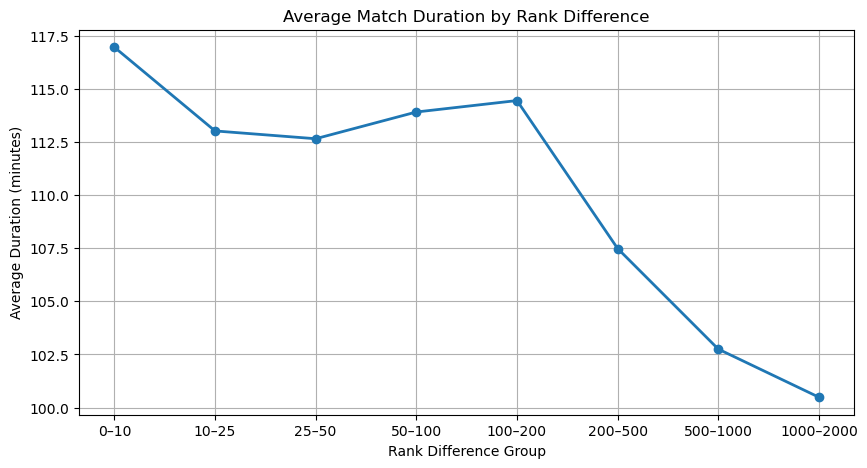

In [46]:
df["rank_diff_group"] = pd.cut(
    df["rank_diff"],
    bins=[0,10,25,50,100,200,500,1000,2000],
    labels=["0–10","10–25","25–50","50–100","100–200","200–500","500–1000","1000–2000"],
    include_lowest=True
)
avg_duration = df.groupby("rank_diff_group", observed=True)["minutes"].mean()

#Plot
plt.figure(figsize=(10,5))
avg_duration.plot(kind="line", marker="o", linewidth=2)

plt.title("Average Match Duration by Rank Difference")
plt.xlabel("Rank Difference Group")
plt.ylabel("Average Duration (minutes)")
plt.grid(True)

plt.show()

In [48]:
df["duration_class"] = pd.cut(
    df["minutes"],
    bins=[0, 90, 150, 600],
    labels=["Short", "Medium", "Long"]
)

features = [
    "rank_diff",
    "winner_age",
    "loser_age",
    "round",
    "best_of",
    "surface_Hard",
    "surface_Clay",
    "surface_Grass",
    "tourney_level_A",
    "tourney_level_M"
]
df = df.dropna(subset=["duration_class"])

X = df[features]
y = df["duration_class"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

display(np.where(y_train.isna() == True))
display(y_train.iloc[5021])
display(df.iloc[5021])

(array([], dtype=int64),)

'Medium'

winner_seed         12.0
winner_ht          193.0
winner_ioc           AUS
winner_age          21.8
loser_seed           0.0
loser_ht           175.0
loser_ioc            BIH
loser_age           24.8
best_of                3
round                  2
minutes             63.0
winner_rank         16.0
loser_rank          66.0
surface_Carpet     False
surface_Clay       False
surface_Grass      False
surface_Hard        True
tourney_level_A    False
tourney_level_D    False
tourney_level_G    False
tourney_level_M     True
rank_diff           50.0
age_diff             3.0
height_diff         18.0
same_country           0
seed_diff           12.0
rank_diff_group    25–50
duration_class     Short
Name: 6776, dtype: object

In [49]:
clf = RandomForestClassifier(
    n_estimators=300, 
    max_depth=12, 
    random_state=42
)
clf.fit(X_train,y_train)

RandomForestClassifier(max_depth=12, n_estimators=300, random_state=42)

/var/folders/37/4gbwkhqj12v7ywvlm_hd44g40000gn/T/ipykernel_2547/2919131873.py:48: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  heat = matches_test.pivot_table(


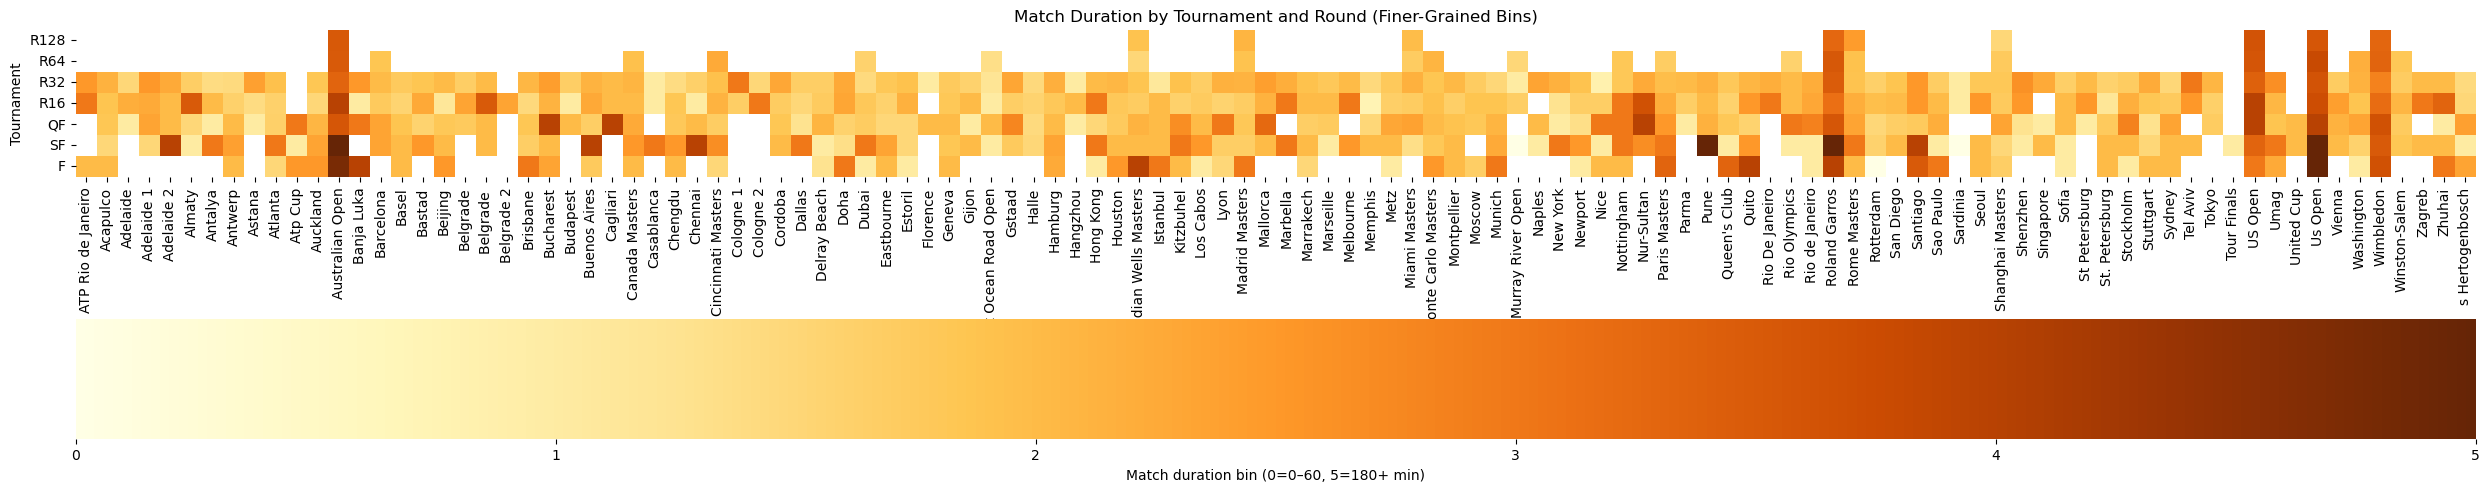

In [50]:
all_matches = pd.concat(
    [pd.read_csv(f"data/atp_matches_{i}.csv") for i in range(2015, 2025)],
    ignore_index=True
)
#Removing unneeded columns
unnecessary = [
    'score','w_ace','w_df','w_svpt','w_1stIn','w_1stWon','w_2ndWon','w_SvGms',
    'w_bpSaved','w_bpFaced','l_ace','l_df','l_svpt','l_1stIn','l_1stWon','l_2ndWon',
    'l_SvGms','l_bpSaved','l_bpFaced','winner_name','loser_name','winner_ioc','loser_ioc',
    'winner_entry','loser_entry','tourney_id','tourney_date','winner_seed',
    'loser_seed','winner_ht','loser_ht', 'draw_size', 'match_num', 'winner_id', 'winner_hand',
    'loser_id', 'loser_hand', 'winner_rank_points', 'loser_rank_points'
]

matches = all_matches.drop(columns=unnecessary, errors='ignore')

# ---------- 1. Create finer-grained duration bins ----------
# use np.inf so every non-negative duration falls into some bin (no NaNs from pd.cut)
bins = [0, 60, 90, 120, 150, 180, np.inf]   # 6 bins
bin_labels = [0, 1, 2, 3, 4, 5]

matches['duration_bin'] = pd.cut(
    matches['minutes'],
    bins=bins,
    labels=bin_labels,
    include_lowest=True
)

# convert categorical -> numeric codes; NaNs (if any) become -1, we mask them out
matches['duration_bin'] = matches['duration_bin'].astype('float')   # stays 0..5, no int-cast issue

# ---------- 2. Predictions for test set (clf, X_test already exist) ----------
y_pred = clf.predict(X_test)
matches_test = matches.loc[X_test.index].copy()

# here we use the *binned actual duration* as the value to plot
matches_test['pred_bin'] = matches_test['duration_bin']

# ---------- 3. Order rounds on x-axis ----------
round_order = ["R128", "R64", "R32", "R16", "R8", "QF", "SF", "F"]
matches_test['round'] = pd.Categorical(
    matches_test['round'],
    categories=round_order,
    ordered=True
)

# ---------- 4. Tournament × Round matrix ----------
heat = matches_test.pivot_table(
    index="tourney_name",
    columns="round",
    values="pred_bin",
    aggfunc="mean"
).sort_index()

heat = heat.T

# ---------- 5. Colorful heatmap (many bins, high-contrast colormap) ----------
plt.figure(figsize=(25, 10))
sns.heatmap(
    heat,
    cmap="YlOrBr",                 # very colorful
    vmin=0,
    vmax=len(bin_labels) - 1,     # 0..5
    square=True,
    linewidths=0,
    cbar_kws={
        "orientation": "horizontal",
        "label": "Match duration bin (0=0–60, 5=180+ min)"
    },
    annot=False
)

plt.title("Match Duration by Tournament and Round (Finer-Grained Bins)")
plt.xlabel("Round")
plt.ylabel("Tournament")
plt.xticks(rotation=90)
plt.yticks()
plt.tight_layout()
plt.show()